In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.integrate import quad
from scipy.optimize import fsolve
from quantecon.quad import *
import seaborn as sns

%matplotlib inline
sns.set_style('whitegrid')

np.random.seed(42)  # For reproducability

# 2 Introduction to Numerical Integration with a basic MacCall model

In this notebook I'd like to introduce you to two very useful toolboxes: random variable distributions and numerical integration.

The ideal application for our level is the MacCall model we saw in class. It has a distribution and an integral, so fits perfectly. We will come back to this model to solve it in a more sophisticated way than 'do the algebra and then plug in numbers'.

First I'll spare a few words on how the most popular statistical library works in python. Then I'll briefly illustrate what is numerical integration (also known as quadrature) and the principles behind it. I will also introduce you to a basic function that calculates definite integrals.

Using both tools you'll calculate a numerical solution for the MacCall model and then do the "increase the spread" exercise again.

<img src=c_banner.png>

## 1 The stats module and distributions

Random variables and statistical distributions pop up all the time in economics (not only in macro!).

Computers can handle randomness - in a somehow limited way. In the top of this notebook you can find how we *set the seed*
```
np.random.seed(42)
```
meaning that we give the computer a starting point for a sampling algorithm that gives sequences of otherwise random numbers. This number (the seed) determines the sequence of all of the number you will obtain "at random". This is good for replicating the results of others - as the random numbers you draw are the same as me.

[The stats module of scipy](https://docs.scipy.org/doc/scipy-0.18.0/reference/stats.html) has a comprehensive list of different random variable distributions. Each of them then have modules to get the pdf, the cdf and to draw random numbers. For example, the following code generates a [normal distribution](https://docs.scipy.org/doc/scipy-0.18.0/reference/generated/scipy.stats.norm.html#scipy.stats.norm):

In [2]:
Norm_dis = stats.norm()

This is just a "frozen" random variable $x \sim N(0,1)$. If wee need to produce the probability distribution function (pdf) we just need to call `Norm_dis.pdf`

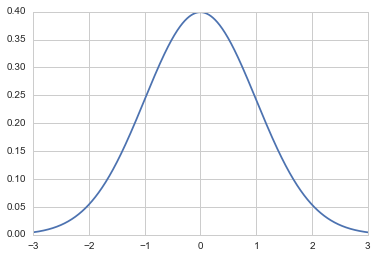

In [3]:
xs = np.linspace(-3,3,1000)           # creates grid for plotting
plt.plot(xs,Norm_dis.pdf(xs))    # plots the pdf
plt.show()

Suppose we need a normal distribution with mean 1 and standard deviation 0.7. That can be simply done using the optional commands `loc` (location) for the mean and `scale` for the standard deviation:

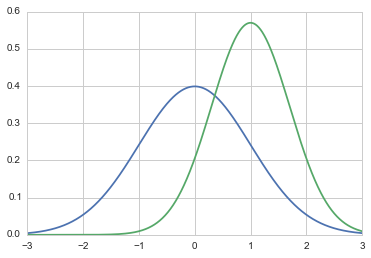

In [4]:
Norm_dis2 = stats.norm(loc=1,scale=0.7) # creates the new distribution

plt.plot(xs,Norm_dis.pdf(xs))           # plots the old pdf
plt.plot(xs,Norm_dis2.pdf(xs))          # plots the new pdf
plt.show()

Sampling random variables is very easy too:

In [5]:
Norm_dis.rvs()     # draws one random number

0.4967141530112327

In [6]:
Norm_dis.rvs(10)   # draws 10 random numbers from $N(0,1)$

array([-0.1382643 ,  0.64768854,  1.52302986, -0.23415337, -0.23413696,
        1.57921282,  0.76743473, -0.46947439,  0.54256004, -0.46341769])

With this module we can do things like roll dice or flip coins (using a [discrete uniform distribution](https://docs.scipy.org/doc/scipy-0.18.0/reference/generated/scipy.stats.randint.html#scipy.stats.randint)):

In [7]:
dice = stats.randint(low=1,high=7)        # low is the minimun (included) and high the maximum (NOT included)
print "5 rolls of a dice: ",dice.rvs(5)

5 rolls of a dice:  [4 2 6 5 4]


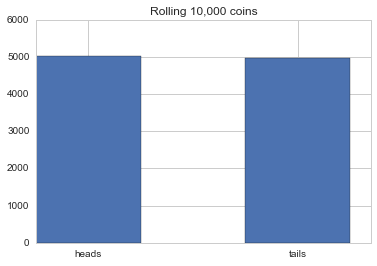

In [8]:
# Plots 10,000 coin flips
coin = stats.randint(low=0,high=2)
sample = coin.rvs(10000)
num, bins = np.histogram(sample, bins=[0,1,2])
plt.bar(bins[:-1],num,width=0.5)
plt.xticks([0.25,1.25],['heads','tails'])
plt.title('Rolling 10,000 coins')
plt.show()

That's all we need to know for out problem today. But we will eventually come back to the [stats module](https://docs.scipy.org/doc/scipy-0.18.0/reference/stats.html). Feel free to take a look at all of the functions it has. It can make python work as a mini stata for econometrics!

## 2  Numerical Integration - aka Quadrature

In many applications in economics, we face problems that involve calculating and evaluating integrals.

You may think:"well, take the antiderivative and evaluate it!". However, there are reasons why not doing just that is feasible:

- You may not be able to take the antiderivative (it doesn't exists or it involves complex numbers)
- You may be able to take the derivative, but it is very complex / hard to evaluate numerically.
- You may not know the function itself! (think about econometrics, and "sampling" an unknow function f(x))

For all of these occasions, we'll need to use a set of tools called *numerical integration* or *quadrature*. These tools go back to ancient Greece, where people had no calculators nor computers. Actually, they didn't even have integrals as such, but they were geometry nerds and wanted to calculare areas of complicated polygons. You can read their story [here](https://en.wikipedia.org/wiki/Numerical_integration#History).

### 2.1 How Quadrature works

So the good news is if those guys were able to find a way, it can't be terribly complicated. And indeed, the method is very simple: approximate the area below a curve (function) by drawing rectangles undernead it, then add up their areas:

<img src=https://upload.wikimedia.org/wikipedia/commons/e/ea/Integration_rectangle.png> </img>

It is sometimes more useful to use trapezoids instead:

<img src=https://upload.wikimedia.org/wikipedia/commons/a/a8/Calkowanie_numeryczne-metoda_trapezow.png> </img>

Bellow is some code borrowed from [quantecon gallery](http://nbviewer.jupyter.org/github/QuantEcon/QuantEcon.notebooks/blob/master/quadrature.ipynb) that illustrates how extending the trapezoid rule from one to many points makes the approximation of the area better. Don't look too much into the code itself, it may be a bit advanced (and I will change it in the future). Just execute the cells and look at the resulting picture at the end.

In [11]:
# Define function
c = np.array([2.00, -1.00, 0.50, 0.0])
f = np.poly1d(c)

In [12]:
# Basic Figure Setup
xmin = -1.0
xmax =  1.0
xwid = xmax-xmin
n = 401
x = np.linspace(xmin, xmax, n)
y = f(x)
ymin = min(y)
ymax = max(y)
ywid = ymax - ymin
ymin = ymin - 0.2*ywid
ymax = ymax + 0.1*ywid

In [13]:
def trap_intervals(nint):
    "Split the region defined above into nint intervals"
    nnode = nint + 1
    xnode = np.linspace(xmin, xmax, nnode)
    ynode = f(xnode)
    
    # Calculate bins
    z = np.zeros(n)
    for i in range(1, nnode):
        k = np.where((x >= xnode[i-1]) & (x <= xnode[i]))[0]
        z[k] = ynode[i-1] + ((x[k]-xnode[i-1])*(ynode[i]-ynode[i-1]) 
                             /(xnode[i]-xnode[i-1]))
    
    return z, xnode, ynode

In [ ]:
def plot_regions(z, xnode, ynode, ax):
    """
    Take "interval" data z and plot it with the actual function
    on the axes ax.
    """
    nint = xnode.size - 1
    
    # plot
    ax.plot(x, y)
    ax.plot(x, z, "r--", lw=2)
    ax.fill_between(x, z, ymin+0.02, color="#8AC627",
                    alpha=0.4)
    
    # annotate
    # Set ticks
    ax.set_xticks(xnode)
    x_tick_labs = [r"$x_0=a$"]
    x_tick_labs += [r"$x_%i$" % i for i in range(1, nint)]
    x_tick_labs += [r"$x_%i=b$" % nint]
    ax.set_xticklabels(x_tick_labs, fontsize=14)
    ax.xaxis.set_ticks_position('bottom')
    ax.set_yticks(())

    # remove borders
    for d in ["left", "right", "top", "bottom"]:
        ax.spines[d].set_visible(False)
    
    # set plot limits
    ax.set_ylim(ymin, ymax)
    ax.set_xlim(xmin-0.05, xmax+0.05)
    
    # add lines to show bins
    ax.vlines(xnode, ymin, ynode, color="k", linestyles="-", lw=.25)
        
    return

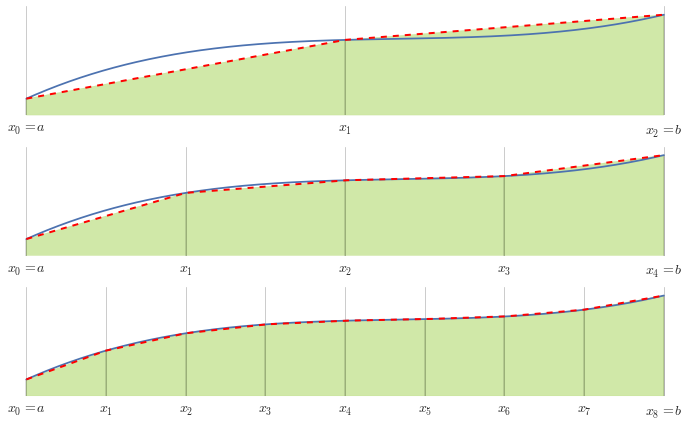

In [20]:
# Plotting bit
fig, axs = plt.subplots(3, 1, figsize=(10, 6))
fig.tight_layout()
plot_regions(*trap_intervals(2), ax=axs[0])
plot_regions(*trap_intervals(4), ax=axs[1])
plot_regions(*trap_intervals(8), ax=axs[2])

plt.show()

As you can see, quadrature tries to stricke a balance: more points deliver more accuracy, but more points require the computer to take more function evaluations, and that can make it slow.  For example, from the first picture to the second, you can see we gain a lot more accuracy. But from the second to the third, the gains are not that great. If we keep on going the gains become smaller and smaller, yet the computer has to do more and more work.

Getting the right balance is not an easy task, but lucky us some people have already made algorithms and functions that do a great job at it - automatically.

### 2.2 Numerical integration in python

Now our functions are usually a bit more complicated and sometimes involve more than one variable. For these cases we need more sophisticated tools that cut the spaces between the rectagles/trapezoids in clever ways. 

For example, take the handy quantecon library [quantecon.quad](http://quanteconpy.readthedocs.io/en/latest/_modules/quantecon/quad.html): it contains mostly functions that will break your function into a set of *nodes* or integration points and *weights*. Once you have those, all you have to do is take their weighted sum - these methods transform nasty integrals into easy sums. Yes, even computer scientists find integrals unsettling and sums easy.

More interestingly, it contains speciall quadrature (or integration) functions for specific distributions (normal, lognormal, gamma...) these sure will come handy very soon.

An alternative that we will use here is the [scipy library on integration](https://docs.scipy.org/doc/scipy-0.18.1/reference/integrate.html). We will use below the function `quad`.

This function works very simply: it takes as arguments a function, a lower ($a$) and an upper bound ($b$) and returns the value of the integral between $a$ and $b$.  For example, say we want to calculate the area below the squate root function between 0 and 4:

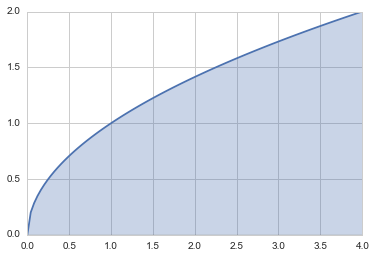

In [31]:
xs = np.linspace(0,4,100)                       # grid of xs
plt.plot(xs,np.sqrt(xs))                        # plot sqrt(xs)
plt.fill_between(xs, np.sqrt(xs),alpha=0.3)     # fill_between, a most useful function
plt.show()

We can call quad with our function, lower and upper bounds:

In [25]:
quad(np.sqrt,0,4)

(5.333333333333335, 5.921189464667503e-15)

The first number is our integral, the second is the error - pretty tiny as you can see.

Because this function was very easy, we can calculate the antiderivative and evaluate it:

$$\int_0^4{\sqrt{x}dx} = \int_0^4{x^{\frac{1}{2}}dx} = \Big[\frac{x^{\frac{3}{2}}}{\frac{3}{2}}\Big]^4_0 = \frac{4^{\frac{3}{2}}}{\frac{3}{2}}$$

In [33]:
4**(1.5)/1.5

5.333333333333333

Good job `quad`! Feel free to try different functions and see how `quad` performs. You may like to take a look at the [instruction manual](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.integrate.quad.html#scipy.integrate.quad) of `quad` to see what it is capable of. If you find yourself bored this Christmas, that is.

Finally, if you want to learn more, I suggest [the wikipedia entry](https://en.wikipedia.org/wiki/Numerical_integration) for numerical integration, with a more detailed an elegant explanation of what I said above.

-----------
## 2.3 The MacCall model, take 1

Time is discrete. There is a mass of homogeneous workers that discount time at rate $\frac{1}{1+r}$. 

When unemployed, they earn $z$ and with a probability $\alpha$ they receive a job offer at the begining of next period. The job offer consists of a wage $w$ drawn at random from exogenous distribution $F(w)$, which is continous and known for all workers. 

Once employed, workers earn $w$ until the job end with exogenous probability $\lambda$.

With some algebra manipulation you can arrive to the main equation of the model: the reservation wage threshold
(1)
$$w_R - z = \frac{\alpha}{\lambda+r} \int_{w_R}^{\bar{w}}{(1-F(w'))dw'}   $$ 

Where $\hat{w}$ is the wage that makes workers indifferent between accepting or rejecting a job (and keep searching).

--------------
To solve this problem numerically (find the reservation wage) we'll need to assume some parameters and a wage distribution, create an objective function, and let the computer do its magic and find the solution. This time this will involve an integral over a distribution!

For starters, let's assume a normal distribution centered around 1.

> **Task 1:** Create a dictionary with the parameters we need. In particular:
>  - $\alpha$ = 0.3
>  - $\lambda$ = 0.05
>  - $r$ = 0.02
>  - $z$ = 0.6
>
>  And we will need parameters for our distribution:
>  - $\mu$ = 1
>  - $\sigma$ = 0.4
>  - $\bar{w} = 5$ (top wage. Tesla CEO. Harrison Ford in the 70's)

In [35]:
pam1 = {"alpha" : 0.3,
       "lam"    : 0.05,
       "r"      : 0.02,
       "z"      : 0.6,
       "mu"     : 1,
       "sigma"  : 0.4,
       "wtop"   : 5}

> **Task 2:** Create a normal distribution with mean (location) $\mu$ and standard deviation $\sigma$. This will be our F(w').
>
>How many times the worker draws a wage below its unemployment income?

In [6]:
Norm = stats.norm(loc=pam1['mu'],scale=pam1["sigma"])

In [13]:
below = Norm.cdf(pam1['z'])
print "The worker finds a crap offer with probabiliy", np.round(below,2)

The worker finds a crap offer with probabiliy 0.16


Now we need to define the integral. This is done in two steps, as `quad` takes *the name of a function* as input, not any defined function - try it yourself. 

So first you'll need to define the integrand and then create another function that feeds it to `quad`. Remember that the argument for our integral should the *lower bound* $w_R$.

> **Task 3a:** Create the function we need to integrate (take a look back at the reservation wage equation)

In [38]:
def integral_function(x,F=Norm.cdf):
    return 1-F(x)

> **Task 3b:** Create a function that returns the value of the integral of the function you just defined between our target $w_{R}$ and $\bar{w}$

*Hint: remember that `quad` returns* ***two*** *things: the result and the error*

It's always a good practice to try the function in a new cell (remember to use the + button at the top left) just as we did in task 2.

In [60]:
def integral(w,top=pam1["wtop"]):
    result = quad(integral_function,w,top)[0]    # pick the result only, not the error
    return result

Finally, time to create the objective function:

$$z - w_R + \frac{\alpha}{\lambda+r} \int_{w_R}^{\bar{w}}{(1-F(w'))dw'}$$

For the right $w_R$, this should be $0$ - just what we need to feed it into an equation solver.

> **Task 4:** Build the objective function using the integral function defined above.

In [62]:
def RES(w, pams=pam1):
    z,lam,r,alpha = pams['z'], pams['lam'], pams['r'], pams['alpha'] # unpack parameters
    return z - w + (alpha/(r+lam)) * integral(w,top=pams["wtop"])

Ready to rock!

> **Task 5a**: Solve the objective function and find the reservation wage.

In [90]:
sol = fsolve(RES,0.7)
sol

array([ 1.09665414])

> **Task 5b**: Use your result to draw a plot of the right hand side and the left hand side of equation (1). What do they mean in words? Label the lines accordingly.

Calculating the right hand side is tricky because `quad` takes only a scalar (a number) as an argument, and will give you an error if you try to feed it an array (try it!). The solution is simple: go wage by wage, caluclate the right hand side and store the value. This would require creating an empty array and using a `for` loop to fill it in wage by wage. The introduction to python notebooks we saw in November have all the code you need for this.

Moral of the story: as always, the plot is the trickiest part.

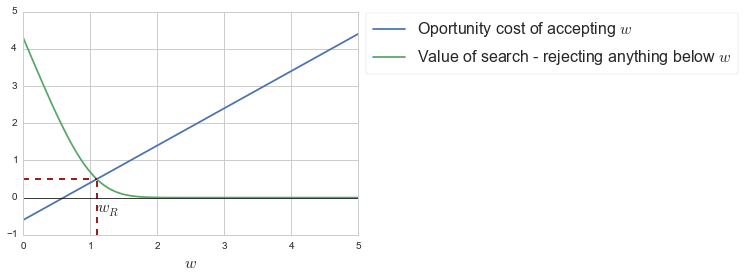

In [135]:
wrange = np.linspace(0,5,100)
n= len(wrange)

lhs = wrange-pam1['z']

rhs = np.empty(n)
for w,i in zip(wrange,range(n)):
    rhs[i] = RES(w)-pam1['z']+w

plt.plot(wrange,lhs,label='Oportunity cost of accepting $w$')
plt.plot(wrange,rhs,label='Value of search - rejecting anything below $w$')
plt.plot((sol,sol) , (-1,sol-pam1['z']),c='darkred',ls='--')
plt.plot((0,sol) , (sol-pam1['z'],sol-pam1['z']),c='darkred',ls='--')
plt.annotate("$w_R$",(sol,-.4),fontsize=16)
plt.axhline(c='black',lw=0.7)
plt.xlabel("$w$",fontsize=16)
plt.legend(loc='best',bbox_to_anchor=(1,1.03),frameon=True,fontsize=16)
plt.show()

Finally, we can use our functions to check what happens to a mean increasing spread: an increase $\sigma$ to 0.8

> **Task 6:** Increase  $\sigma$ to 0.8, find the new reservation wage and plot the change

This task will require more or less coding depending on how you built the functions for the objective function. Remember to store your new results in different variables from above.

In [136]:
Norm2 = stats.norm(loc=pam1['mu'],scale=0.8)
def integral_function(x,F=Norm2.cdf):
    return 1-F(x)

In [137]:
sol2 = fsolve(RES,0.7)
sol2

array([ 1.3486179])

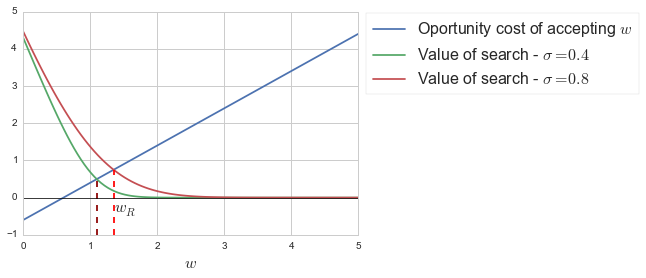

In [140]:
rhs2 = np.empty(n)
for w,i in zip(wrange,range(n)):
    rhs2[i] = RES(w)-pam1['z']+w

plt.plot(wrange,lhs,label='Oportunity cost of accepting $w$')
plt.plot(wrange,rhs,label='Value of search - $\sigma=0.4$')
plt.plot(wrange,rhs2,label='Value of search - $\sigma=0.8$')
plt.plot((sol,sol) , (-1,sol-pam1['z']),c='darkred',ls='--')
plt.plot((sol2,sol2) , (-1,sol2-pam1['z']),c='red',ls='--')
plt.annotate("$w_R$",(sol2,-.4),fontsize=16)
plt.axhline(c='black',lw=0.7)
plt.xlabel("$w$",fontsize=16)
plt.legend(loc='best',bbox_to_anchor=(1,1.03),frameon=True,fontsize=16)
plt.show()

## Recap

That's it for today. We have hopefully learned:

- How to create distributions and random variables in python using `scipy.stats`
- What is numerical integration and its fundamentals
- How to use scipy numerical integration tools to calculate a simple integral
- Solved the MacCall Model numerically using the reservation wage definition

And reviewed plotting and equation solving.

Next week: Solving differential equations using integration. This is the last step that would prepare us for coding the shooting solution to the neoclassical model - back in January.

Happy New Year!

----------------
**Bonus:** you may have noticed that the way we defined them, it was possible for the worker to sample a negative wage. This becomes more apparent when we plot the wage distributions:

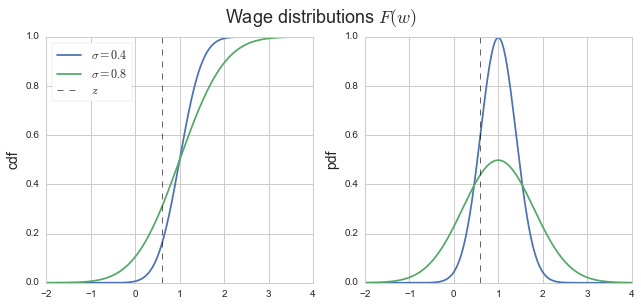

In [275]:
# Bonus: the two PDFs
xs = np.linspace(-2,4,1000)

plt.figure(figsize=(9,4))
plt.suptitle('Wage distributions $F(w)$',fontsize=18,x=0.5,y=1.05)
plt.subplot(121)
plt.plot(xs,Norm.cdf(xs),label="$\sigma=0.4$")
plt.plot(xs,Norm2.cdf(xs),label="$\sigma=0.8$")
plt.axvline(pam1['z'],c='black',lw=0.6,ls='--',label='$z$')
plt.legend(loc='best',frameon=True,fontsize=12)
plt.ylabel("cdf",fontsize=14)

plt.subplot(122)
plt.plot(xs,Norm.pdf(xs))
plt.plot(xs,Norm2.pdf(xs))
plt.axvline(pam1['z'],c='black',lw=0.6,ls='--',label='$z$')
plt.ylabel("pdf",fontsize=14)

plt.tight_layout()
plt.show()

These distributions show that indeed by using a normal distribution the posibility of negative values is positive. In the original distribution with $\sigma=0.4$, the probability of a wage smaller than zero was 0.6%, not too high. But with the incresed spread, now 1 in every 10 wages sampled is negative.

This can be fixed by using a [truncated normal](https://en.wikipedia.org/wiki/Truncated_normal_distribution) instead. We need to normalize the begining and end points (as the [instruction guide](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.truncnorm.html) tells us):

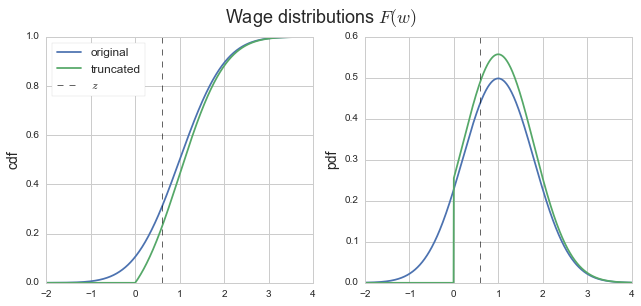

In [276]:
bottom = (0 - 1) / 0.8       # Normalized bottom of the distribution
top = (5 - 1) / 0.8          # Normalized top of the distribution

plt.figure(figsize=(9,4))
plt.suptitle('Wage distributions $F(w)$',fontsize=18,x=0.5,y=1.05)
plt.subplot(121)
plt.plot(xs,Norm2.cdf(xs),label="original")
plt.plot(xs,stats.truncnorm.cdf(xs, bottom, top, loc=1, scale=0.8),label="truncated")
plt.axvline(pam1['z'],c='black',lw=0.6,ls='--',label='$z$')
plt.legend(loc='best',frameon=True,fontsize=12)
plt.ylabel("cdf",fontsize=14)

plt.subplot(122)
plt.plot(xs,Norm2.pdf(xs))
plt.plot(xs,stats.truncnorm.pdf(xs, bottom, top, loc=1, scale=0.8))
plt.axvline(pam1['z'],c='black',lw=0.6,ls='--',label='$z$')
plt.ylabel("pdf",fontsize=14)

plt.tight_layout()
plt.show()